In [1]:
import os
import numpy as np
import matplotlib.pyplot as plt
from scipy.io import loadmat
import mat73
from scipy.ndimage import convolve1d
from numpy import random

In [2]:
path = '../datasets/dataset2_grasping-task/'
fname = os.path.join(path, 'Dataset2.mat')
data = mat73.loadmat(fname)

In [3]:
monkeyL = data['monkeyL']
spks = monkeyL['spikes']
spks = np.asarray(spks)

fs = 1000 # original binning at 1kHz
t_stamps = np.arange(0,spks.shape[0]/fs, 1/fs)

force = monkeyL['force']-1 # zero indexing 
grip = monkeyL['grip']-1 # zero indexing 

In [4]:
# defining task structure
trans = ['CUE_ON', 'CUE_OFF', 'GO'] # cues
trans_ind = [0.7,1,2] # time at which transition occurs (in seconds)

all_cond = ['SG-HF', 'SG-LF', 'PG-HF', 'PG-LF']
all_cond_ind = [(0,0), (0,1), (1,0), (1,1)]

# plotting
cond_colors = [(1,0,1), (1,0.7,1), (0,1,1), (0.7, 1,1)] # rgb values

### Preprocessing and plotting

In [5]:
def gaussian(x, mu, sig):
    return np.exp(-np.power(x - mu, 2.) / (2 * np.power(sig, 2.)))

Text(0.5, 1.0, 'smoothing kernel')

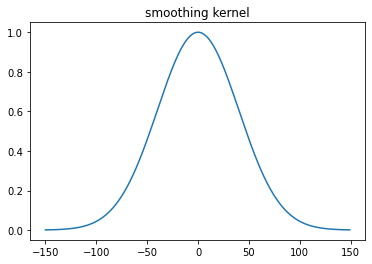

In [6]:
x_kernel = np.arange(-150,150)
y_kernel = gaussian(x_kernel, mu=0, sig=40)
plt.plot(x_kernel, y_kernel)
spks_conv = convolve1d(spks, y_kernel, axis=0)
plt.title('smoothing kernel')

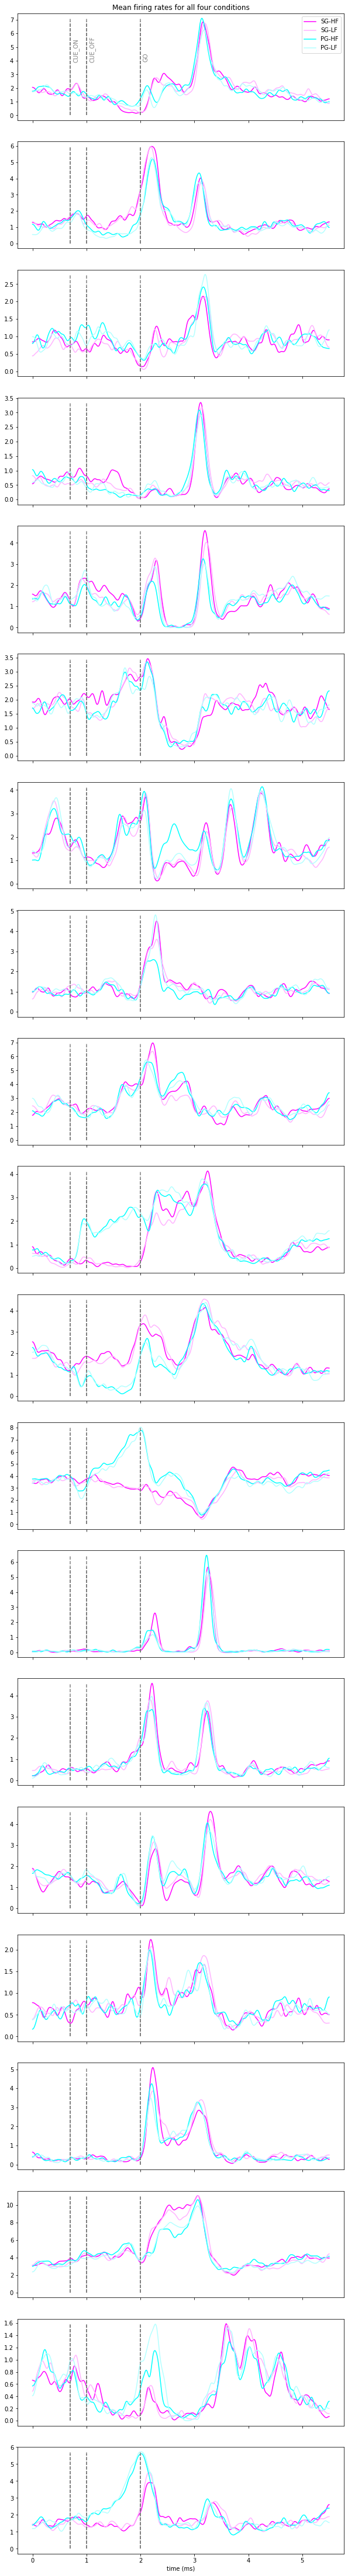

In [7]:
n_plot = 20
_, axs = plt.subplots(n_plot, 1, figsize=(10,4*n_plot))

all_mns = np.zeros((len(t_stamps), spks_conv.shape[1], len(all_cond))) # time x neurons x conditions

for i in range(n_plot):
        
    for (j, cond) in enumerate(all_cond):
        
        grip_ind = all_cond_ind[j][0] # based on above encoding
        force_ind = all_cond_ind[j][1] # based on above encoding
        
        cond_trials = np.logical_and(grip == grip_ind, force == force_ind)
        mn_fr = np.mean(spks_conv[:,i,cond_trials], 1) # indexing and averaging
        
        axs[i].plot(t_stamps, mn_fr, label=cond, c = cond_colors[j])
        axs[i].vlines(trans_ind, ymin=0, ymax=np.max(mn_fr), linestyles='dashed', color='grey')
        
        if (i == 0) & (j == len(all_cond)-1):
            axs[i].legend()
            axs[i].set_xticklabels([])
            axs[i].set_title('Mean firing rates for all four conditions')
            for k in range(len(trans_ind)):
                axs[i].text(trans_ind[k]+0.05, round(np.max(mn_fr)/1.5), trans[k], rotation=90, color='grey')
        elif i == n_plot-1:
            axs[i].set_xlabel('time (ms)')
        else:
            axs[i].set_xticklabels([])

### Bootstrapping to check for divergence at single neuron level

In [8]:
# Use the bootstrap method to compute confidence intervals. 
# How many neurons would you say encode the grip information? 
# For each grip-encoding neuron, how early in the cue/preparatory 
# period can you decode the grip type?

In [9]:
# bootstrapping for neuron and conditions
n_bts = 10
bts_mns_nrn = np.zeros((len(t_stamps), spks_conv.shape[1], len(all_cond), n_bts)) # time x neurons x conditions x bootstraps(no trials)
bts_perc_up = np.zeros((len(t_stamps), spks_conv.shape[1], len(all_cond))) # time x neurons x conditions
bts_perc_down = np.zeros((len(t_stamps), spks_conv.shape[1], len(all_cond)))# time x neurons x conditions


# this could be sped up by avoiding for loops
for i in range(spks_conv.shape[1]): # for all neurons
    
    for j in range(len(all_cond)): # for all conditions

        grip_ind = all_cond_ind[j][0] # based on above encoding
        force_ind = all_cond_ind[j][1] # based on above encoding
        cond_trials = np.logical_and(grip == grip_ind, force == force_ind)

        data = spks_conv[:,i,cond_trials]
        mn_fr = np.mean(spks_conv[:,i,cond_trials], 1) # indexing and averaging
        all_mns[:,i,j] = mn_fr
        
        for k in range(n_bts): # for all bootstraps
            resamp_ind = random.randint(0, data.shape[1], (data.shape[1]))
            data_bts = data[:, resamp_ind]
            data_bts_mn = np.mean(data_bts, 1)
            bts_mns_nrn[:, i, j, k] = data_bts_mn
        
        # percentile confidence intervals
        up = np.percentile(bts_mns_nrn[:,i,j,:], 95, axis=1)
        down = np.percentile(bts_mns_nrn[:,i,j,:], 5, axis=1)
        
        bts_perc_up[:,i,j] = up
        bts_perc_down[:,i,j] = down
        
    if i % 10 == 0:
        print(f'Done bootstrapping mean with neuron {i}.')

Done bootstrapping mean with neuron 0.
Done bootstrapping mean with neuron 10.
Done bootstrapping mean with neuron 20.
Done bootstrapping mean with neuron 30.
Done bootstrapping mean with neuron 40.
Done bootstrapping mean with neuron 50.
Done bootstrapping mean with neuron 60.
Done bootstrapping mean with neuron 70.
Done bootstrapping mean with neuron 80.
Done bootstrapping mean with neuron 90.


In [10]:
pos = [(0,0), (0,1), (1,0), (1,1)]

plotting neuron 9
plotting neuron 10
plotting neuron 11


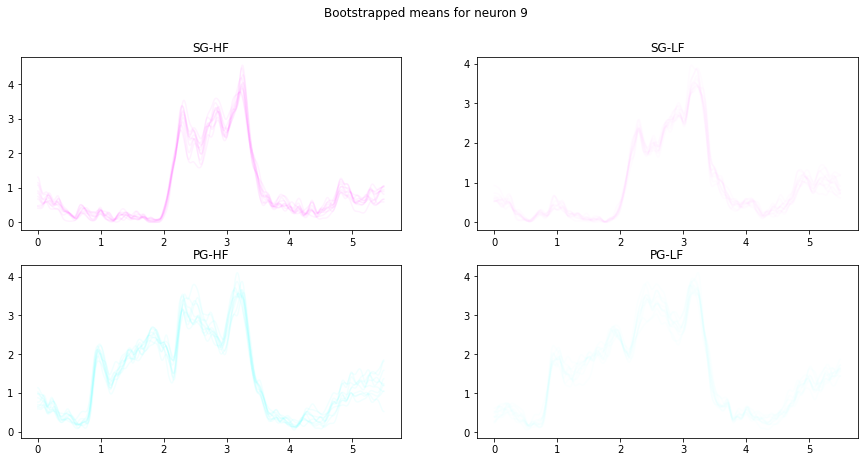

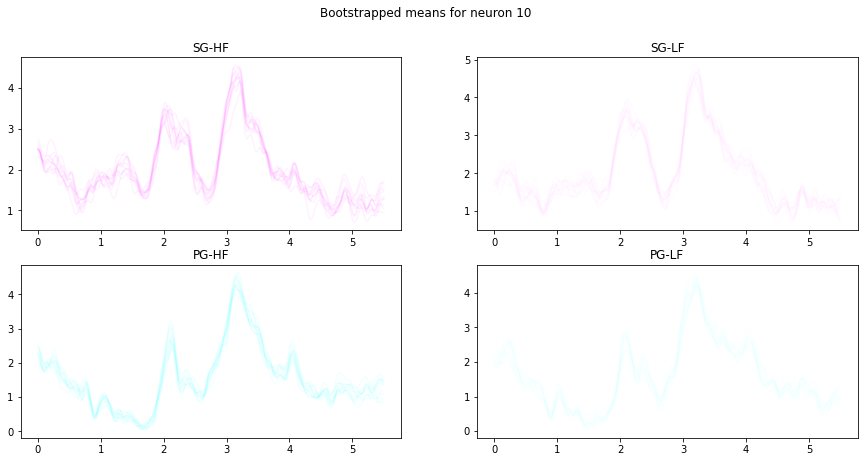

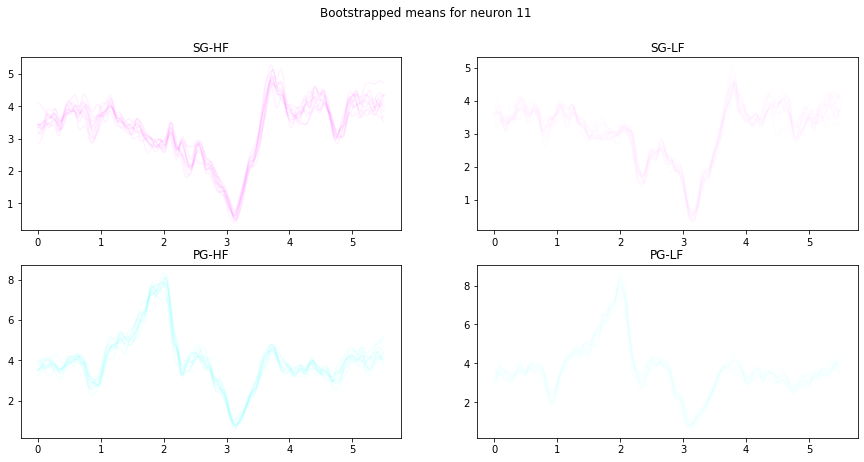

In [11]:
# plotting bootstrapped means for 5 example neurons
for i in range(9,12):
    print(f'plotting neuron {i}')
    fig,axs = plt.subplots(2,2, figsize=(15,7))
    fig.suptitle(f'Bootstrapped means for neuron {i}')
    for j in range(len(all_cond)):
            axs[pos[j]].plot(t_stamps, bts_mns_nrn[:,i,j,:], c = cond_colors[j], alpha = 0.05);
            axs[pos[j]].set_title(all_cond[j])

Text(0.5, 0, 'Time (ms)')

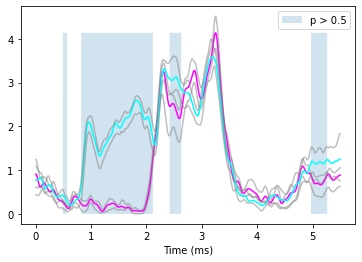

In [12]:
# example neuron separating two conditions (for high force) and plotting significance
i = 9
c_ind_1 = 0
c_ind_2 = 2
for j in range(c_ind_1,c_ind_2+1,2): 
    plt.plot(t_stamps, all_mns[:,i,j], c=cond_colors[j])
    plt.plot(t_stamps, bts_perc_up[:,i,j], c='grey', alpha=0.5)
    plt.plot(t_stamps, bts_perc_down[:,i,j], c='grey', alpha=0.5)
    
t_sig = bts_perc_up[:,i,c_ind_1] < bts_perc_down[:,i,c_ind_2]
plt.fill(t_stamps,t_sig*np.max([all_mns[:,i,c_ind_1], all_mns[:,i,c_ind_2]]), alpha=0.2, label='p > 0.5')
plt.legend()
plt.xlabel('Time (ms)')

### PCA to look at divergence at population level

In [13]:
from sklearn.decomposition import PCA
import plotly.express as px
import plotly.graph_objects as go
import plotly.io as pio
from scipy.stats import zscore
pio.templates.default = 'simple_white'

### PCA second attempt

In [25]:
# scoring before reshaping
all_mns_trunc = all_mns[:int(trans_ind[2]*fs+1),:] # preparatory period
#all_mns_trunc = all_mns # preparatory period (all data)
all_mns_trunc_zscore = zscore(all_mns_trunc)

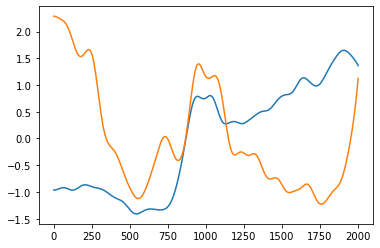

In [26]:
plt.plot(all_mns_trunc_zscore[:,9,3])
plt.plot(all_mns_trunc_zscore[:,9,1])

In [27]:
all_mns_2d = np.concatenate((all_mns_trunc_zscore[:,:,0], all_mns_trunc_zscore[:,:,1], all_mns_trunc_zscore[:,:,2], all_mns_trunc_zscore[:,:,3]))

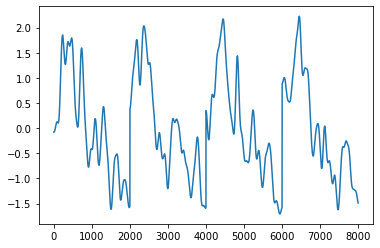

In [28]:
plt.plot(all_mns_2d.T[27,:])

In [29]:
# on trial type means
pca_mn = PCA(n_components=20)
data_pca_mn = all_mns_2d.T
pca_mn.fit(data_pca_mn)
embedding_mn = pca_mn.components_.T

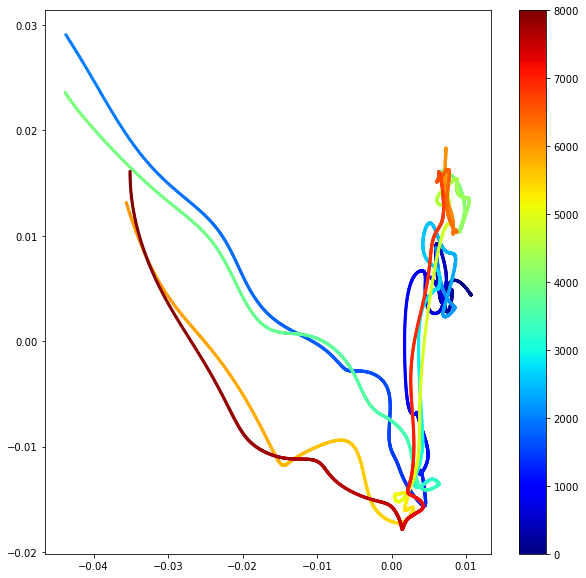

In [30]:
plt.figure(figsize=(10,10))
plt.scatter(embedding_mn[:,0], embedding_mn[:,1], s=5, c=np.arange(0,embedding_mn.shape[0]), cmap='jet')#, c=t_stamps[:int(trans_ind[2]*fs)])

plt.colorbar()

In [31]:
fig = go.Figure(data=go.Scatter3d(
    x=embedding_mn[:,0], 
    y=embedding_mn[:,1], 
    z=embedding_mn[:,2],
    marker=dict(
        size=3,
        color=np.arange(0,len(embedding_mn[:,0])),
    ),    
    # line=dict(
    #     color=np.arange(0,len(embedding_mn[:,0])),
    #     width=3
    # ),
))
fig.update_layout(plot_bgcolor='rgba(1,0,0,0)', width=1500, height=1500)
# fig.write_image(f"exp_analysis/emb_{title}.png")
# fig.write_html(f"exp_analysis/emb_{title}.html")
fig.show()

### Trying UMAP

In [32]:
import umap

In [33]:
reducer = umap.UMAP()
embedding_umap = reducer.fit_transform(data_pca_mn.T)

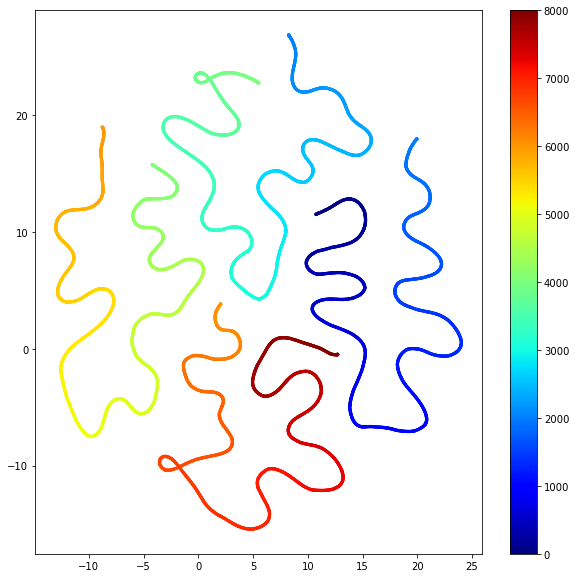

In [34]:
plt.figure(figsize=(10,10))
plt.scatter(embedding_umap[:,0], embedding_umap[:,1], s=5, c=np.arange(0,embedding_umap.shape[0]), cmap='jet')#, c=t_stamps[:int(trans_ind[2]*fs)])

plt.colorbar()

### PCA on single trials